In [41]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime

PARENT_DIR = "/Users/emmawaters/Desktop/Dance/Prod/"
NUM_PARTS = 15
NUM_CHUNKS = 1

song_list = ['Aurora', 'Aphex', 'Armatrading', 'Tnertle', 'Willow', 'Jiggle']
dancer_list = ['Dorissa', 'Dot', 'Falcon', 'Imogen', 'Lia', 'Sophia', 'Sunny']

In [42]:
# FOR COLOR CODING THE NOTEBOOK
from IPython.display import HTML, display
    
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

In [43]:
# INITIALIZE MASTER DICTIONARY
data_init = {
    'song' : [song for song in song_list for i in range(7)],
    'dancer': dancer_list * 6 
}

df = pd.DataFrame(data_init)

In [44]:
# DATA ROUND ONE
set_background('lightblue')

In [45]:
# RAW DATA
set_background('lightblue')

# read_video_to_movement returns the list of joint positions found using openCV
# Also returns a count of the number of joints not found, to be used to measure accuracy
def read_video_to_movement(vidpath):
    data = []
    net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
    cap = cv.VideoCapture(vidpath)

    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Background": 14 }

    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"] ]

    error = 0
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        #frame = cv.rotate(frame, cv.ROTATE_180) #ONLY needed if raw iPhone data
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        net.setInput(cv.dnn.blobFromImage(frame, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
        out = net.forward()
        out = out[:, :15, :, :]

        assert(len(BODY_PARTS) == out.shape[1])

        points = []
        for i in range(len(BODY_PARTS)):
            heatMap = out[0, i, :, :]
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]
            if conf > 0.1:
                points.append(np.array([x, y]))
            else:
                points.append(np.array([None,None]))
                error += 1

        data.append(points)
    return (data, error)

# COLLECT VIDEOS
vid_names = []
dir_list = os.listdir(PARENT_DIR)
for i in dir_list:
    if i.endswith(".mp4"):
        vid_names.append(i)
        
raw_name_dict = {'Aurora':[], 'Aphex':[], 'Armatrading':[], 'Tnertle':[], 'Willow':[], 'Jiggle':[]}
for vid in vid_names:
    name_split = vid.split('.')[0].split('_')
    raw_name_dict[name_split[1]].append(vid)

for i in raw_name_dict:
    raw_name_dict[i].sort()
    
OG_vid_name_list = raw_name_dict['Aurora'] + raw_name_dict['Aphex'] + raw_name_dict['Armatrading'] + raw_name_dict['Tnertle'] + raw_name_dict['Willow'] + raw_name_dict['Jiggle']
        
df['vid_name_0'] = OG_vid_name_list

In [46]:
# COLLECT RAW MOTION TRACKING DATA AND COLLECT ERRORS
set_background('lightblue')

FRAMES_BY_SONG = {}
raw_dance_data = []
errors = []

time_start = datetime.datetime.now()

for song in song_list:
    print(song)
    num_frames = float('inf')
    song_raw_data = []
    for dancer in dancer_list:
        print(dancer)
        (movement, error) = read_video_to_movement(os.path.join(PARENT_DIR, dancer + '_' + song +'.mp4'))
        errors.append(error/(len(movement)*NUM_PARTS)) # percent of joints not captured
        raw_dance_data.append(movement) # haha should be in correct order
        if len(movement) < num_frames:
            num_frames = len(movement)
    
    FRAMES_BY_SONG[song] = num_frames

time_end = datetime.datetime.now()
print(time_end-time_start)

df['raw_dance_0'] = raw_dance_data

Aurora
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Aphex
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Armatrading
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Tnertle
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Willow
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Jiggle
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
0:53:04.117940


In [66]:
set_background('lightblue')
df['errors_0'] = errors

<bound method NDFrame.head of            song   dancer               vid_name_0  \
0        Aurora  Dorissa       Dorissa_Aurora.mp4   
1        Aurora      Dot           Dot_Aurora.mp4   
2        Aurora   Falcon        Falcon_Aurora.mp4   
3        Aurora   Imogen        Imogen_Aurora.mp4   
4        Aurora      Lia           Lia_Aurora.mp4   
5        Aurora   Sophia        Sophia_Aurora.mp4   
6        Aurora    Sunny         Sunny_Aurora.mp4   
7         Aphex  Dorissa        Dorissa_Aphex.mp4   
8         Aphex      Dot            Dot_Aphex.mp4   
9         Aphex   Falcon         Falcon_Aphex.mp4   
10        Aphex   Imogen         Imogen_Aphex.mp4   
11        Aphex      Lia            Lia_Aphex.mp4   
12        Aphex   Sophia         Sophia_Aphex.mp4   
13        Aphex    Sunny          Sunny_Aphex.mp4   
14  Armatrading  Dorissa  Dorissa_Armatrading.mp4   
15  Armatrading      Dot      Dot_Armatrading.mp4   
16  Armatrading   Falcon   Falcon_Armatrading.mp4   
17  Armatrading 

In [47]:
# COMPUTE CHARACTERISTIC VECTORS PER DANCE
set_background('lightblue')

def vectorize_movement(movement, num_chunks, NUM_PARTS, NUM_FRAMES):
    move_vec = []
    chunk_size = int(NUM_FRAMES/num_chunks)
    for n in range(num_chunks):
        for joint in range(NUM_PARTS):
            x_pos_disp = 0
            x_neg_disp = 0
            y_pos_disp = 0
            y_neg_disp = 0
            
            for i in range(chunk_size):
                if (n*chunk_size + i + 1 >= len(movement)):
                    break
                prev_frame = movement[n*chunk_size + i]
                frame = movement[n*chunk_size + i + 1]

                if prev_frame[joint].all() and frame[joint].all():
                    disp = prev_frame[joint] - frame[joint]

                    if disp[0] > 0:
                        x_pos_disp += disp[0]
                    else:
                        x_neg_disp += disp[0]
                    if disp[1] > 0:
                        y_pos_disp += disp[1]
                    else:
                        y_neg_disp += disp[1]
            move_vec += [x_pos_disp, x_neg_disp, y_pos_disp, y_neg_disp]
    return move_vec

characteristic_vectors = []
for raw_motion in df['raw_dance_0']:
    move_vec = vectorize_movement(raw_motion, NUM_CHUNKS, NUM_PARTS, FRAMES_BY_SONG[song])
    characteristic_vectors.append(np.array(move_vec))
    
df['char_vecs_0'] = characteristic_vectors

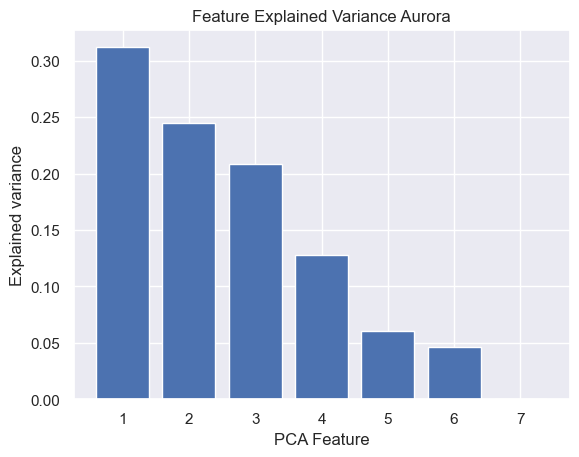

[3.11896405e-01 2.45161896e-01 2.08213901e-01 1.28176810e-01
 6.06829277e-02 4.58680612e-02 6.70855402e-33]


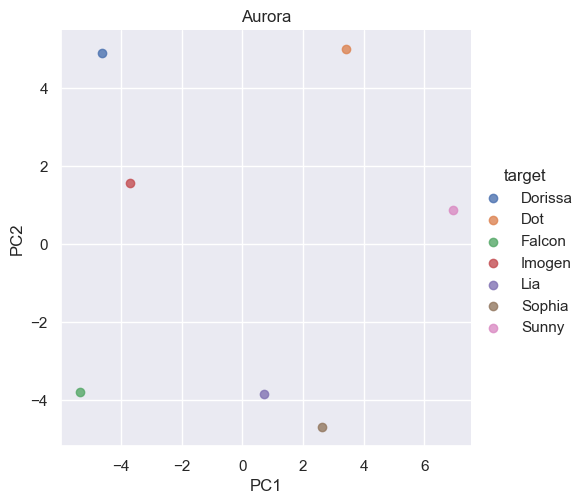

[[-4.62986483  4.88554892]
 [ 3.41573282  4.99303901]
 [-5.36618429 -3.79110331]
 [-3.69417747  1.55804708]
 [ 0.71985922 -3.82778915]
 [ 2.6224377  -4.68641026]
 [ 6.93219685  0.86866771]]


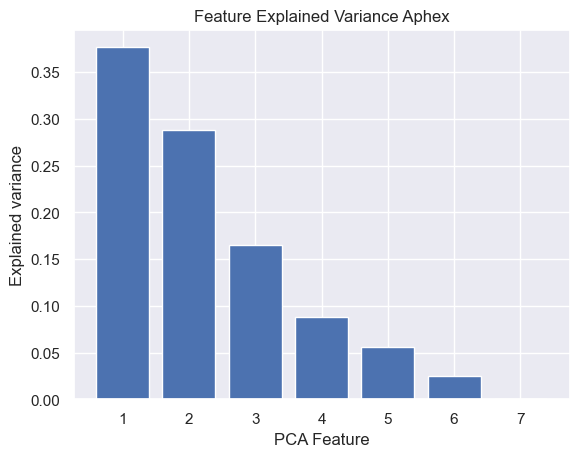

[3.76596142e-01 2.88484827e-01 1.65514760e-01 8.79575744e-02
 5.64325553e-02 2.50141414e-02 6.30290799e-33]


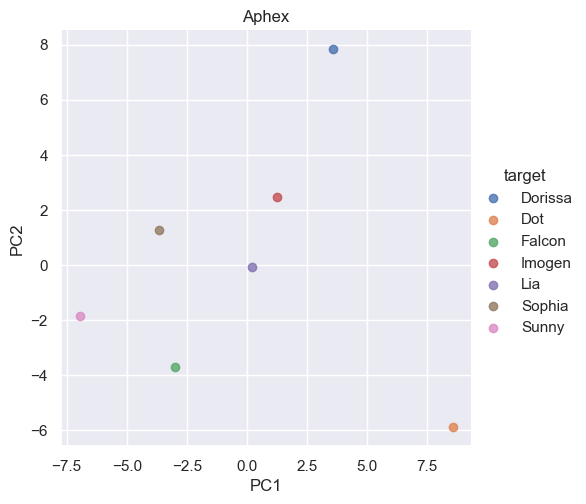

[[ 3.57958059  7.84304824]
 [ 8.55025642 -5.9067718 ]
 [-2.98286405 -3.71081644]
 [ 1.24612049  2.44973485]
 [ 0.21923525 -0.06976694]
 [-3.6567737   1.24660366]
 [-6.95555499 -1.85203156]]


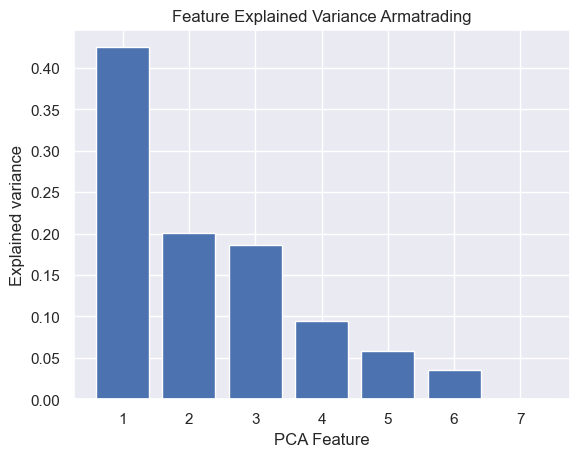

[4.24897383e-01 2.00801823e-01 1.86515642e-01 9.47686567e-02
 5.82050675e-02 3.48114283e-02 4.45683625e-33]


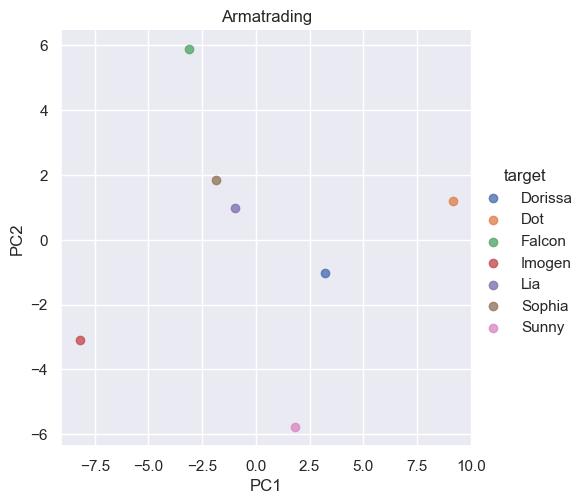

[[ 3.20287727 -1.01520804]
 [ 9.14697927  1.1991767 ]
 [-3.11837438  5.87841859]
 [-8.19741475 -3.09167598]
 [-0.97688041  0.98549075]
 [-1.85252475  1.82695279]
 [ 1.79533775 -5.78315481]]


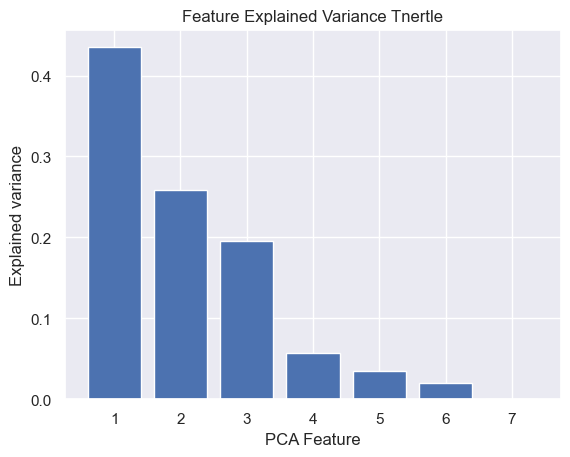

[4.34957372e-01 2.58138973e-01 1.95046334e-01 5.67871585e-02
 3.49150909e-02 2.01550713e-02 1.01656173e-32]


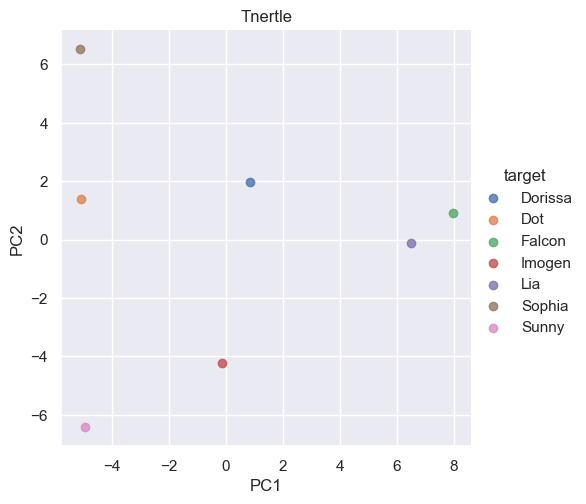

[[ 0.85624957  1.96284759]
 [-5.08567621  1.38710691]
 [ 7.95489225  0.89383949]
 [-0.14207285 -4.23442647]
 [ 6.48622065 -0.11059789]
 [-5.12059652  6.52729875]
 [-4.94901688 -6.42606839]]


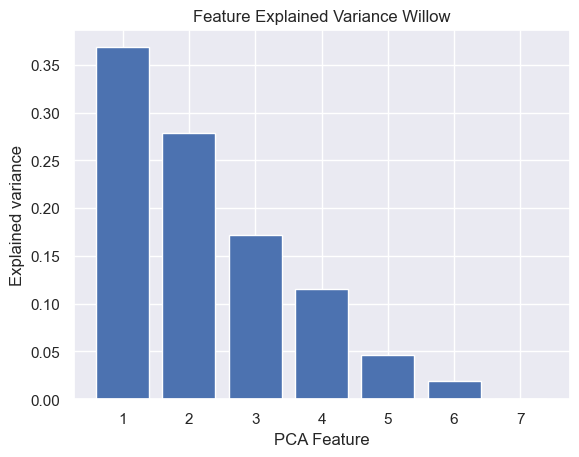

[3.68370427e-01 2.78298376e-01 1.72273913e-01 1.15074505e-01
 4.63965848e-02 1.95861947e-02 1.30655992e-32]


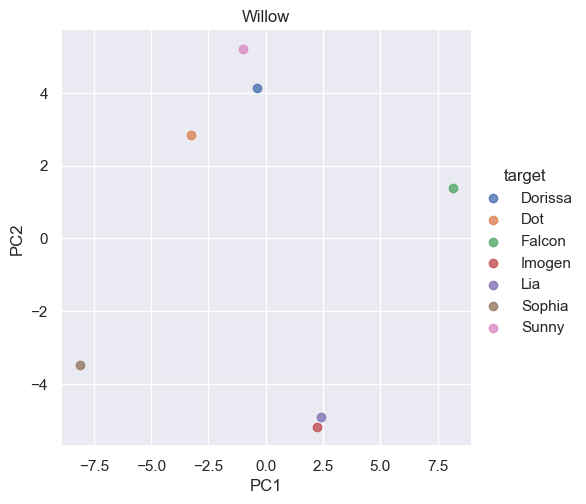

[[-0.39650637  4.12216104]
 [-3.2675243   2.83174803]
 [ 8.14628327  1.38713328]
 [ 2.22110657 -5.189327  ]
 [ 2.40776341 -4.89217455]
 [-8.11103589 -3.46411493]
 [-1.00008669  5.20457414]]


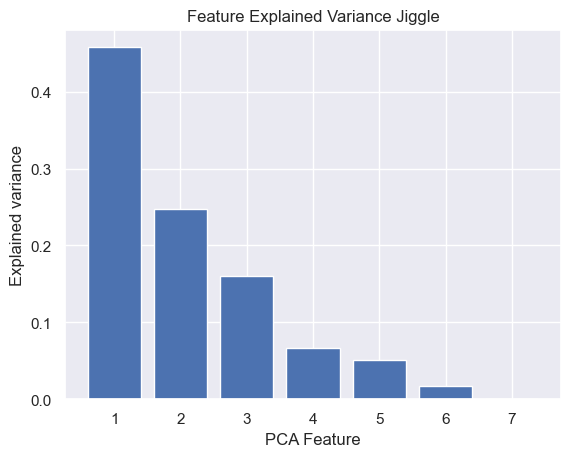

[4.57672108e-01 2.47528424e-01 1.60627519e-01 6.66044696e-02
 5.09584714e-02 1.66090089e-02 1.14419578e-32]


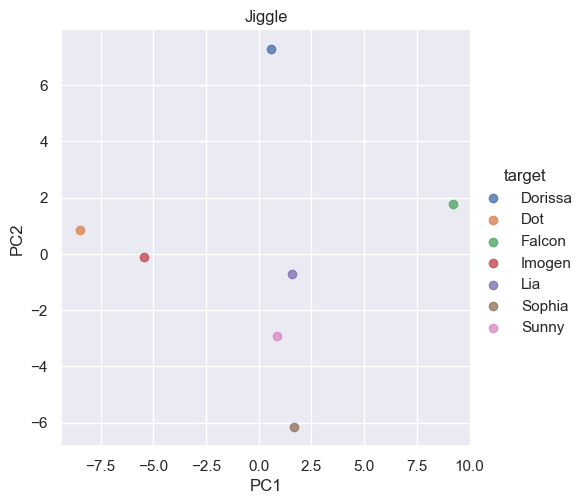

[[ 0.60607272  7.28935346]
 [-8.48588701  0.84571393]
 [ 9.19197423  1.75985734]
 [-5.41704761 -0.09954641]
 [ 1.57015909 -0.7211441 ]
 [ 1.67360541 -6.16716508]
 [ 0.86112318 -2.90706914]]


<bound method NDFrame.head of            song   dancer               vid_name_0  \
0        Aurora  Dorissa       Dorissa_Aurora.mp4   
1        Aurora      Dot           Dot_Aurora.mp4   
2        Aurora   Falcon        Falcon_Aurora.mp4   
3        Aurora   Imogen        Imogen_Aurora.mp4   
4        Aurora      Lia           Lia_Aurora.mp4   
5        Aurora   Sophia        Sophia_Aurora.mp4   
6        Aurora    Sunny         Sunny_Aurora.mp4   
7         Aphex  Dorissa        Dorissa_Aphex.mp4   
8         Aphex      Dot            Dot_Aphex.mp4   
9         Aphex   Falcon         Falcon_Aphex.mp4   
10        Aphex   Imogen         Imogen_Aphex.mp4   
11        Aphex      Lia            Lia_Aphex.mp4   
12        Aphex   Sophia         Sophia_Aphex.mp4   
13        Aphex    Sunny          Sunny_Aphex.mp4   
14  Armatrading  Dorissa  Dorissa_Armatrading.mp4   
15  Armatrading      Dot      Dot_Armatrading.mp4   
16  Armatrading   Falcon   Falcon_Armatrading.mp4   
17  Armatrading 

In [95]:
# RUN PCA (round 0)
set_background('lightblue')

def generate_X(song):
    song_df = df.loc[df['song'] == song]
    char_vec_set = song_df['char_vecs_0']
    move_vec_list = []
    for char_vec in char_vec_set:
        move_vec_list.append(char_vec)
    X = np.array(move_vec_list)
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled

def show_scree(song, X):
    pca_7comp = PCA(n_components=7)
    pca_7fit = pca_7comp.fit(X)

    plt.bar(
        range(1,len(pca_7comp.explained_variance_ratio_)+1),
        pca_7comp.explained_variance_ratio_
        )
    plt.xlabel('PCA Feature')
    plt.ylabel('Explained variance')
    plt.title('Feature Explained Variance ' + song)
    plt.show()
    print(pca_7comp.explained_variance_ratio_)

def show_pca_2plot(song, X):
    pca_2comp = PCA(n_components=2)
    pca_2fit = pca_2comp.fit_transform(X)
    
    pca_df = pd.DataFrame(data=pca_2fit, columns=['PC1', 'PC2'])
    pca_df['target'] = ['Dorissa', 'Dot', 'Falcon', 'Imogen', 'Lia', 'Sophia', 'Sunny']
    
    sns.set()
    sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=pca_df, 
        hue='target', 
        fit_reg=False, 
        legend=True
        )

    plt.title(song)
    plt.show()
    return pca_2fit
    
fit_list = []
# GENERATE PCA TABLES & PLOTS
for song in song_list:
    X = generate_X(song)
    show_scree(song, X)
    fit = show_pca_2plot(song, X)
    print(fit)
    
    for point in fit:
        fit_list.append(np.array(point))
    
df['fit_0'] = fit_list
df.head
    

In [67]:
df.to_csv('DataPostPCA')

In [71]:
new_df = pd.read_csv('DataPostPCA')
char_vecs_new = new_df['char_vecs_0']

In [73]:
type(char_vecs_new)

pandas.core.series.Series

In [74]:
type(char_vecs_new[0])

str

In [110]:
def make_dist_dict(names, points):
    dist_dict = {}
    for dancer in range(len(names)):
        distances = []
        for comp in range(len(names)):
            dist = np.sqrt(np.sum(np.square(points[dancer] - points[comp])))
            distances.append((dist, names[comp]))
        distances.sort()
        dist_dict[names[dancer]] = [x[1] for x in distances]
    return dist_dict

for song in song_list:
    song_df = df.loc[df['song'] == song]
    char_vec_set = song_df['char_vecs_0'].values
    char_vec_dist_dict = make_dist_dict(dancer_list, char_vec_set)
    
    pca_points = song_df['fit_0'].values
    pca_dist_dict = make_dist_dict(dancer_list, pca_points)
    
    print(char_vec_dist_dict)
    print(pca_dist_dict)
    print()
    

{'Dorissa': ['Dorissa', 'Dot', 'Imogen', 'Lia', 'Sunny', 'Falcon', 'Sophia'], 'Dot': ['Dot', 'Dorissa', 'Sunny', 'Lia', 'Sophia', 'Imogen', 'Falcon'], 'Falcon': ['Falcon', 'Lia', 'Dorissa', 'Sophia', 'Sunny', 'Dot', 'Imogen'], 'Imogen': ['Imogen', 'Dorissa', 'Lia', 'Dot', 'Sophia', 'Sunny', 'Falcon'], 'Lia': ['Lia', 'Sunny', 'Sophia', 'Falcon', 'Imogen', 'Dot', 'Dorissa'], 'Sophia': ['Sophia', 'Lia', 'Sunny', 'Dot', 'Falcon', 'Imogen', 'Dorissa'], 'Sunny': ['Sunny', 'Lia', 'Dot', 'Sophia', 'Dorissa', 'Imogen', 'Falcon']}
{'Dorissa': ['Dorissa', 'Imogen', 'Dot', 'Falcon', 'Lia', 'Sophia', 'Sunny'], 'Dot': ['Dot', 'Sunny', 'Imogen', 'Dorissa', 'Lia', 'Sophia', 'Falcon'], 'Falcon': ['Falcon', 'Imogen', 'Lia', 'Sophia', 'Dorissa', 'Dot', 'Sunny'], 'Imogen': ['Imogen', 'Dorissa', 'Falcon', 'Lia', 'Dot', 'Sophia', 'Sunny'], 'Lia': ['Lia', 'Sophia', 'Falcon', 'Imogen', 'Sunny', 'Dot', 'Dorissa'], 'Sophia': ['Sophia', 'Lia', 'Sunny', 'Falcon', 'Imogen', 'Dot', 'Dorissa'], 'Sunny': ['Sunny', 'D